Notebook for baseline model with transformed data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/02456 Deep learning/Final project/')
os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive/02456 Deep learning/Final project'

In [2]:
## Imports

%matplotlib inline
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pydantic import BaseModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import random
import cv2

In [5]:
## Set up

# Paths
data_path_arrays = 'carseg_data/arrays'

# Class label map color (assume class labels have been mapped to 0-9)
class Label(BaseModel):
    class_value: int
    color: tuple
    car_part: str

class_values = range(0, 10)
colors = [(255, 255, 255), (255, 165, 0), (0, 128, 0), (255, 255, 0), (0, 255, 255),
          (128, 0, 128), (144, 238, 144), (0, 0, 255), (255, 192, 203), (0, 0, 0)]
car_parts = ["background", "hood", "front door", "rear door", "frame", "rear quater panel", "trunk lid", "fender", "bumper", "rest of car"]

classes = [Label(class_value = cv, color=c, car_part=cp) for cv, c, cp in zip(class_values, colors, car_parts)]

class_to_color = {c.class_value : c.color for c in classes}

# class_to_color = {
#     0: (255, 255, 255),  # White (Background)
#     1: (255, 165, 0),  # Orange (Hood)
#     2: (0, 128, 0),    # Dark Green (Front door)
#     3: (255, 255, 0),  # Yellow (Rear door)
#     4: (0, 255, 255),  # Cyan (Frame)
#     5: (128, 0, 128),  # Purple (Rear quarter panel)
#     6: (144, 238, 144),  # Light Green (Trunk lid)
#     7: (0, 0, 255),    # Blue (Fender)
#     8: (255, 192, 203),  # Pink (Bumper)
#     9: (0, 0, 0)      # Black (Rest of the car)
# }

In [7]:
## Utlilities

def plot_image(image, grayscale=False):
    # Plots a single image on rgb 0-255 scale
    if torch.is_tensor(image):
        image = image.detach().cpu().permute((1, 2, 0)).numpy()
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        cmap = 'gray' if grayscale else None
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
        plt.show()


def segment_image(image, labels, grayscale=False):
    # Segments an image based on class labels using color map
    # Returns segmented image as tensor
    if torch.is_tensor(image):
        # Convert tensor to numpy arrays
        image = image.detach().cpu().permute(1, 2, 0).numpy()
        labels = labels.detach().cpu().numpy()

    # Create (rows, cols, 3) array
    segmented_image = np.zeros(image.shape[:2]+(3,))

    # Color the pixels based on the class values
    # Excluding class 0 and class 90 if want to include background and rest of the car
    for class_value, color in class_to_color.items():
        #if class_value != 0 and class_value != 90:
        segmented_image[labels == class_value] = color

    # If want to include background and rest of the car
    # segmented_image[label == 0] = image[label == 0]
    # segmented_image[label == 90] = image[label == 90]

    # Convert to tensor
    segmented_image = torch.from_numpy(segmented_image).permute(2, 0, 1).long()

    return segmented_image

def plot_grid_segmented_images(images, labels, grayscale=False):
    # Plots a grid of segmented images (tensors)
    segmented_images = []
    for image, label in zip(images, labels):
        segmented_image = segment_image(image, label)
        segmented_images.append(segmented_image)

    plot_image(torchvision.utils.make_grid(segmented_images, nrow=4), grayscale=grayscale)


In [26]:
## Transform images

# Convert to grayscale since there should be no benifit (I think) by using colors
# for segmenting the car parts (most of the time the car is made of the same color
# anyways so...)

grayscale = True
skip_rest_of_car = False
image_size = (256,256)

def transform(image, label):
    # Function to transform data (training and testing)

    # Convert to grayscale
    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Resize image
    image = cv2.resize(image, image_size, interpolation=cv2.INTER_LINEAR)
    label = cv2.resize(label, image_size, interpolation=cv2.INTER_NEAREST)

    # Add channel dimension if grayscale
    if grayscale:
        image = np.expand_dims(image, axis=-1)

    return image, label


def augment(image, label):
    # Function to augment data (training data)

    # Randomly scale the image and label
    scale_x = random.uniform(1.0, 1.2)
    scale_y = random.uniform(1.0, 1.2)
    image = cv2.resize(image, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_LINEAR)
    label = cv2.resize(label, None, fx=scale_x, fy=scale_y, interpolation=cv2.INTER_NEAREST)

    # Randomly crop the image and label
    final_shape = image_size
    rows, cols = image.shape[:2]
    x = random.randint(0, cols - final_shape[1])
    y = random.randint(0, rows - final_shape[0])
    image = image[y:y + final_shape[0], x:x + final_shape[1]]
    label = label[y:y + final_shape[0], x:x + final_shape[1]]

    # Randomly adjust the color of the image
    if not grayscale:
        r_adjust = random.uniform(0.5, 1.5)
        g_adjust = random.uniform(0.5, 1.5)
        b_adjust = random.uniform(0.5, 1.5)
        image[:, :, 0] = image[:, :, 0] * r_adjust
        image[:, :, 1] = image[:, :, 1] * g_adjust
        image[:, :, 2] = image[:, :, 2] * b_adjust
        image[image > 255] = 255
        image[image < 0] = 0

    # Flip the image and label horizontally with a 50% chance
    if random.choice([True, False]):
        image = cv2.flip(image, 1)  # Horizontal flip
        label = cv2.flip(label, 1)  # Horizontal flip for label

    # Flip the image and label vertically with a 50% chance
    if random.choice([True, False]):
        image = cv2.flip(image, 0)  # Vertical flip
        label = cv2.flip(label, 0)  # Vertical flip for label

    # Rotate the image and label slightly (up to +/- 15 degrees)
    angle = random.uniform(-15, 15)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR)
    label = cv2.warpAffine(label, rotation_matrix, (cols, rows), flags=cv2.INTER_NEAREST)

    return image, label


def remove_rest_of_car(labelled_image):
    rest_of_car_label = 9
    labelled_image[labelled_image == rest_of_car_label] = 0
    return labelled_image


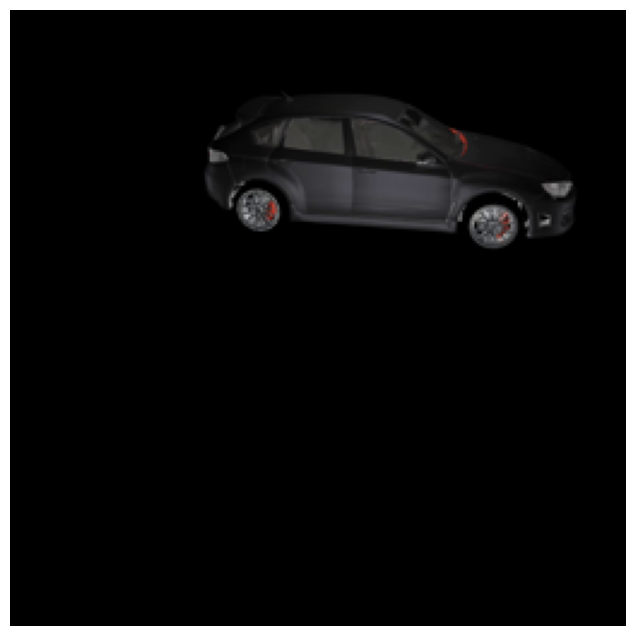

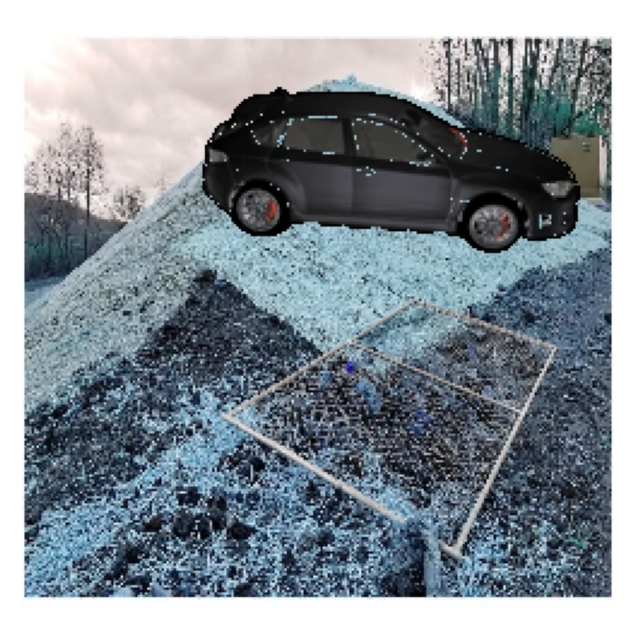

In [14]:
## Add backgrounds to cad images

backgrounds_path = 'carseg_data/images/landscapes'
backgrounds_files = [file for file in os.listdir(backgrounds_path)][:100]   # only use subset of 100 backgrounds to speed up training

def add_background(image, mask):
    # Function that adds a random background to an image with mask
    background_file = random.choice(backgrounds_files)
    background = cv2.imread(os.path.join(backgrounds_path, background_file))
    background = cv2.resize(background, image_size, interpolation=cv2.INTER_LINEAR)
    background_pixels = (mask == 0)
    image[background_pixels] = background[background_pixels]
    return image

car_img = np.load('carseg_data/arrays/black_5_doors_0002.npy')
img = car_img[:,:,:3]
mask = car_img[:,:,3]
plot_image(img)
img = add_background(img, mask)
plot_image(img)

In [29]:
## Segmented image data

num_cad_img = 100   # number of cad images for black and orange, respectively
test_idx = np.arange(1,31)
test_ids = [f"photo_00{i:02d}.npy" for i in test_idx]
real_image_pattern = re.compile(r'.*photo.*')
black_cad_pattern = re.compile(r'.*black.*')
orange_cad_pattern = re.compile(r'.*orange.*')

class SegmentedImageDataset(TensorDataset):
    def __init__(self, data_folder_arrays, train, transform=None):
        self.data_folder = data_folder_arrays
        self.data_files = os.listdir(data_folder_arrays)
        self.train = train
        self.transform = transform
        if self.train:
            # Exclude the test filenames to create the training dataset
            self.data_files = [file for file in self.data_files if file not in test_ids]
            # All real images of cars
            real = [file for file in self.data_files if real_image_pattern.match(file)]
            # 50 random black cad images and 50 random orange cad images
            black = [file for file in self.data_files if black_cad_pattern.match(file)]
            orange = [file for file in self.data_files if orange_cad_pattern.match(file)]
            # Concatenate
            self.data_files = real + random.sample(black, num_cad_img) + random.sample(orange, num_cad_img)
        else:
            # Include only the test filenames for the test dataset
            self.data_files = [file for file in self.data_files if file in test_ids]

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        file_name = os.path.join(self.data_folder, self.data_files[idx])
        image_data = np.load(file_name)
        image = image_data[:,:,:3]
        class_labels = image_data[:,:,3]
        class_labels = class_labels//10   # map class labels to 0-9
        # Add background to CAD images
        if not real_image_pattern.match(file_name):
            image = add_background(image, class_labels)
        # Augment training data
        if self.train:
            image, class_labels = augment(image, class_labels)
        # Transform
        if self.transform:
            image, class_labels = self.transform(image, class_labels)
        # Error check - TODO: VEIT EKKI ALVEG AFHVERJU ÞETTA GERIST sTUNDUM... (eflaust transformation en veit ekki afhverju?)
        if np.isnan(image).any() or np.isnan(class_labels).any():
            print("NaN values found in the image or label!")
            raise ValueError("NaN values found in the image or label!")

        # min-max normalization for the image
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        if skip_rest_of_car:
            class_labels = remove_rest_of_car(class_labels)

        return torch.from_numpy(image).permute(2, 0, 1).float(), torch.tensor(class_labels).long()

    def split_train_validation(self, validation_split):
        # Function to split data into training and validation sets
        num_samples = len(self.data_files)
        num_val_samples = int(validation_split * num_samples)
        random.shuffle(self.data_files)

        return self.data_files[:-num_val_samples], self.data_files[-num_val_samples:]


batch_size = 8
num_workers = 0
validation_split = 0.2

train_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=True, transform=transform)
validation_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=True, transform=transform)
test_dataset = SegmentedImageDataset(data_folder_arrays=data_path_arrays, train=False, transform=transform)
train_dataset.data_files, validation_dataset.data_files = train_dataset.split_train_validation(validation_split)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Training data:


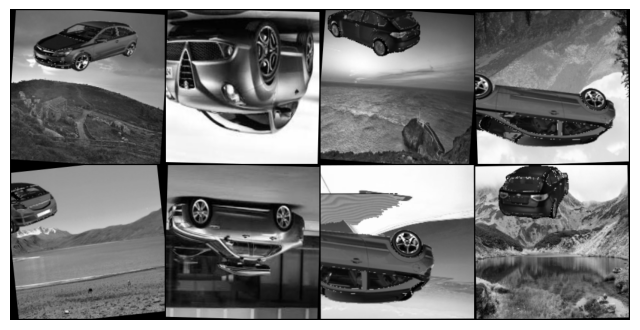

Validation data:


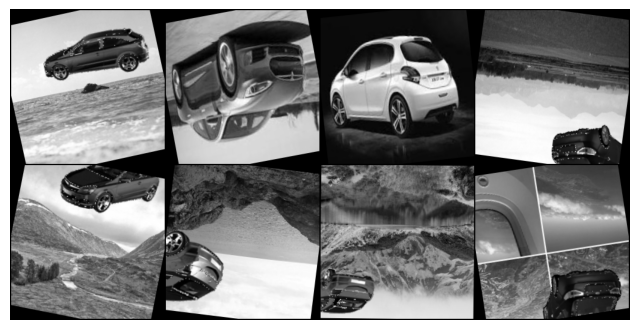

Testing data:


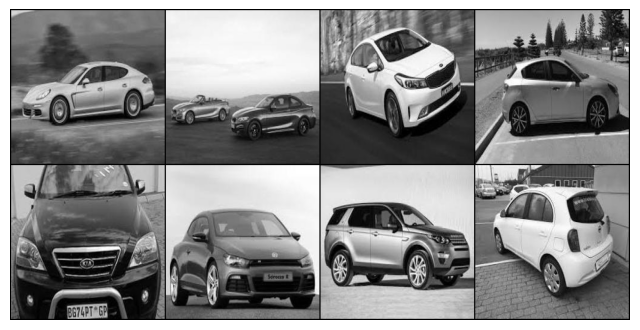

In [34]:
print('Training data:')
images_train, masks_train = next(iter(train_dataloader))
plot_image(torchvision.utils.make_grid(images_train, nrow=4), grayscale=grayscale)

print('Validation data:')
images_val, masks_val = next(iter(validation_dataloader))
plot_image(torchvision.utils.make_grid(images_val, nrow=4), grayscale=grayscale)

print('Testing data:')
images_test, masks_test = next(iter(test_dataloader))
plot_image(torchvision.utils.make_grid(images_test, nrow=4), grayscale=grayscale)

Training data:


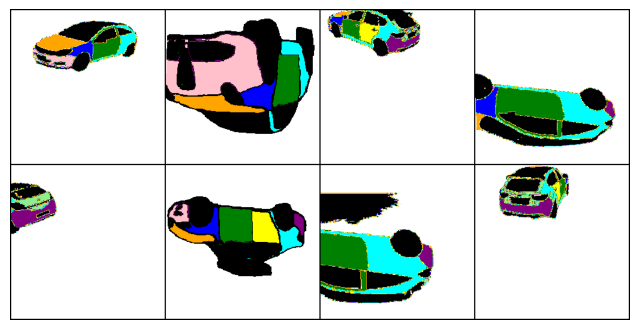

Validation data:


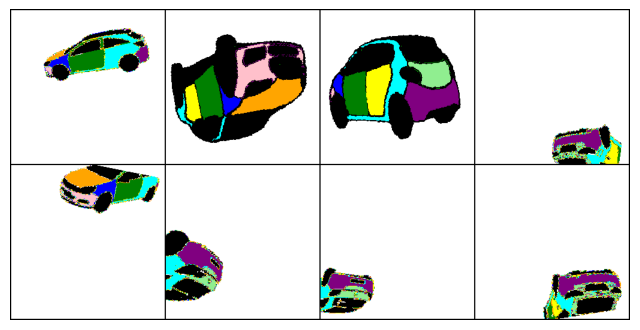

Testing data:


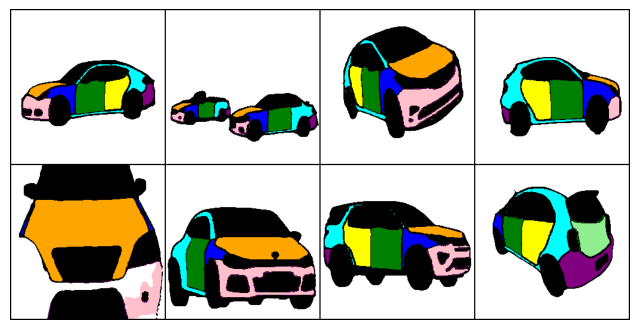

In [36]:
print('Training data:')
plot_grid_segmented_images(images_train, masks_train)

print('Validation data:')
plot_grid_segmented_images(images_val, masks_val)

print('Testing data:')
plot_grid_segmented_images(images_test, masks_test)

In [37]:
# TODO: mynd neðst í vinstra horni er léleg í test gögnum... (kannski taka hana út eða replace-a með gömul því hún var betri minnir mig
# þetta gæti nefnilega haft mikil áhrif á niðurstöðuna sem við fáum úr test)

In [19]:
:## Model

import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expanding path
        self.up1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.up2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(64 + 32, 32)

        self.out = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Contracting path
        c1 = self.enc1(x)
        p1 = self.pool(c1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)

        c3 = self.enc3(p2)

        # Expanding path
        up1 = self.up1(c3)
        merge1 = torch.cat([up1, c2], dim=1)
        d1 = self.dec1(merge1)

        up2 = self.up2(d1)
        merge2 = torch.cat([up2, c1], dim=1)
        d2 = self.dec2(merge2)

        out = self.out(d2)
        return out

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )


model = UNet(in_channels=3, out_channels=10)
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up1): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec1): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

In [ ]:
## Custom loss functions - (NOT WORKING ATM)

class IoULoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, logits, targets):
        #print(logits.grad_fn)
        # Apply softmax to get class probabilities
        probs = F.softmax(logits, dim=1)
        #print(probs.grad_fn)

        # Calculate IoU for each class
        iou_sum = 0.0
        for i in range(self.num_classes):
            true_class = targets == i
            pred_class = probs[:, i, :, :]
            intersection = torch.sum(true_class.float() * pred_class)
            union = torch.sum(true_class.float()) + torch.sum(pred_class) - intersection
            iou = (intersection + self.smooth) / (union + self.smooth)
            iou_sum += iou

        # Average IoU over all classes
        average_iou = iou_sum / self.num_classes

        # Convert IoU to IoU loss
        iou_loss = 1.0 - average_iou

        return iou_loss

    # def forward(self, outputs, targets):
    #     print(outputs.grad_fn)
    #     outputs = torch.argmax(outputs, dim=1).float()   # get class value from logits
    #     #outputs.requires_grad=True
    #     print(outputs.grad_fn)
    #     iou_sum = 0.0
    #     for i in range(self.num_classes):
    #         true_class = (targets== i)
    #         pred_class = (outputs == i)
    #         intersection = torch.sum(true_class * pred_class)
    #         union = torch.sum(true_class ) + torch.sum(pred_class) - intersection
    #         iou = (intersection + self.smooth) / (union + self.smooth)
    #         iou_sum += iou

    #     return Variable(1-iou_sum/self.num_classes, requires_grad=True)


class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, outputs, targets):
        dice_sum = 0.0
        for i in range(self.num_classes):
            true_class = (targets == i)
            pred_class = (outputs == i)
            intersection = torch.sum(true_class * pred_class)
            union = torch.sum(true_class) + torch.sum(pred_class)
            dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_sum += dice

        return 1-dice_sum/self.num_classes



In [20]:
## Model configuration

num_classes = 9 if skip_rest_of_car else 10
num_channels = 1 if grayscale else 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=num_channels, out_channels=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
#criterion = IoULoss(num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
device

device(type='cuda')

In [22]:
## Train

#num_epochs = 200
num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_training_loss = 0.0

    # Wrap dataloader with tqdm for a loading bar
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_training_loss += loss.item() * images.size(0)   # multiply with size of batch since final batch of the dataloader might be smaller

    # Valdiation loss
    running_validation_loss = 0.0
    with torch.no_grad():
        model.eval()
        for images, masks in validation_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_validation_loss += loss.item() * images.size(0)

    epoch_training_loss = running_training_loss / len(train_dataloader.dataset)
    epoch_validation_loss = running_validation_loss / len(validation_dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {epoch_training_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {epoch_validation_loss:.4f}")


Epoch 1/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1/50] Training Loss: 1.4234
Epoch [1/50] Validation Loss: 1.2172


Epoch 2/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2/50] Training Loss: 1.0904
Epoch [2/50] Validation Loss: 1.2074


Epoch 3/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3/50] Training Loss: 1.0562
Epoch [3/50] Validation Loss: 1.1773


Epoch 4/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4/50] Training Loss: 1.0434
Epoch [4/50] Validation Loss: 1.1719


Epoch 5/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5/50] Training Loss: 1.0299
Epoch [5/50] Validation Loss: 1.1477


Epoch 6/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6/50] Training Loss: 1.0098
Epoch [6/50] Validation Loss: 1.1556


Epoch 7/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [7/50] Training Loss: 1.0099
Epoch [7/50] Validation Loss: 1.1308


Epoch 8/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [8/50] Training Loss: 1.0042
Epoch [8/50] Validation Loss: 1.1254


Epoch 9/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [9/50] Training Loss: 1.0042
Epoch [9/50] Validation Loss: 1.1127


Epoch 10/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [10/50] Training Loss: 1.0008
Epoch [10/50] Validation Loss: 1.1237


Epoch 11/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [11/50] Training Loss: 0.9880
Epoch [11/50] Validation Loss: 1.1538


Epoch 12/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [12/50] Training Loss: 0.9853
Epoch [12/50] Validation Loss: 1.1056


Epoch 13/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [13/50] Training Loss: 1.0042
Epoch [13/50] Validation Loss: 1.1208


Epoch 14/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [14/50] Training Loss: 0.9848
Epoch [14/50] Validation Loss: 1.0896


Epoch 15/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [15/50] Training Loss: 0.9770
Epoch [15/50] Validation Loss: 1.1122


Epoch 16/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [16/50] Training Loss: 0.9614
Epoch [16/50] Validation Loss: 1.0818


Epoch 17/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [17/50] Training Loss: 0.9346
Epoch [17/50] Validation Loss: 1.1081


Epoch 18/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [18/50] Training Loss: 0.9583
Epoch [18/50] Validation Loss: 1.0697


Epoch 19/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [19/50] Training Loss: 0.9322
Epoch [19/50] Validation Loss: 1.1179


Epoch 20/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [20/50] Training Loss: 0.9336
Epoch [20/50] Validation Loss: 1.0860


Epoch 21/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [21/50] Training Loss: 0.9522
Epoch [21/50] Validation Loss: 1.0839


Epoch 22/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [22/50] Training Loss: 0.9405
Epoch [22/50] Validation Loss: 1.1043


Epoch 23/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [23/50] Training Loss: 0.9349
Epoch [23/50] Validation Loss: 1.0724


Epoch 24/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [24/50] Training Loss: 0.9199
Epoch [24/50] Validation Loss: 1.0741


Epoch 25/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [25/50] Training Loss: 0.9109
Epoch [25/50] Validation Loss: 1.0671


Epoch 26/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [26/50] Training Loss: 0.9059
Epoch [26/50] Validation Loss: 1.0628


Epoch 27/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [27/50] Training Loss: 0.9032
Epoch [27/50] Validation Loss: 1.0333


Epoch 28/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [28/50] Training Loss: 0.9075
Epoch [28/50] Validation Loss: 1.0632


Epoch 29/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [29/50] Training Loss: 0.9138
Epoch [29/50] Validation Loss: 1.1220


Epoch 30/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [30/50] Training Loss: 0.8994
Epoch [30/50] Validation Loss: 1.0272


Epoch 31/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [31/50] Training Loss: 0.8824
Epoch [31/50] Validation Loss: 1.0148


Epoch 32/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [32/50] Training Loss: 0.8799
Epoch [32/50] Validation Loss: 1.0375


Epoch 33/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [33/50] Training Loss: 0.8739
Epoch [33/50] Validation Loss: 1.0267


Epoch 34/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [34/50] Training Loss: 0.8964
Epoch [34/50] Validation Loss: 1.0232


Epoch 35/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [35/50] Training Loss: 0.8878
Epoch [35/50] Validation Loss: 1.0388


Epoch 36/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [36/50] Training Loss: 0.8687
Epoch [36/50] Validation Loss: 0.9841


Epoch 37/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [37/50] Training Loss: 0.8490
Epoch [37/50] Validation Loss: 0.9980


Epoch 38/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [38/50] Training Loss: 0.8617
Epoch [38/50] Validation Loss: 1.0010


Epoch 39/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [39/50] Training Loss: 0.8669
Epoch [39/50] Validation Loss: 1.0344


Epoch 40/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [40/50] Training Loss: 0.8496
Epoch [40/50] Validation Loss: 1.0217


Epoch 41/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [41/50] Training Loss: 0.8828
Epoch [41/50] Validation Loss: 1.0354


Epoch 42/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [42/50] Training Loss: 0.8327
Epoch [42/50] Validation Loss: 0.9805


Epoch 43/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [43/50] Training Loss: 0.8204
Epoch [43/50] Validation Loss: 0.9718


Epoch 44/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [44/50] Training Loss: 0.8846
Epoch [44/50] Validation Loss: 1.0057


Epoch 45/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [45/50] Training Loss: 0.8485
Epoch [45/50] Validation Loss: 0.9997


Epoch 46/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [46/50] Training Loss: 0.8436
Epoch [46/50] Validation Loss: 1.0019


Epoch 47/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [47/50] Training Loss: 0.8373
Epoch [47/50] Validation Loss: 0.9982


Epoch 48/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [48/50] Training Loss: 0.8318
Epoch [48/50] Validation Loss: 0.9564


Epoch 49/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [49/50] Training Loss: 0.8175
Epoch [49/50] Validation Loss: 0.9834


Epoch 50/50:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [50/50] Training Loss: 0.8062
Epoch [50/50] Validation Loss: 0.9552


In [ ]:
# TODO: er stundum að lenda í því að fá nan - örugglega út af transformation en veit ekki alveg hvaðan??

In [23]:
## Save and load model

path_to_model = 'model_v2_grayscale'
#torch.save(model, path_to_model)
#model = torch.load(path_to_model)
model.eval();

Test:


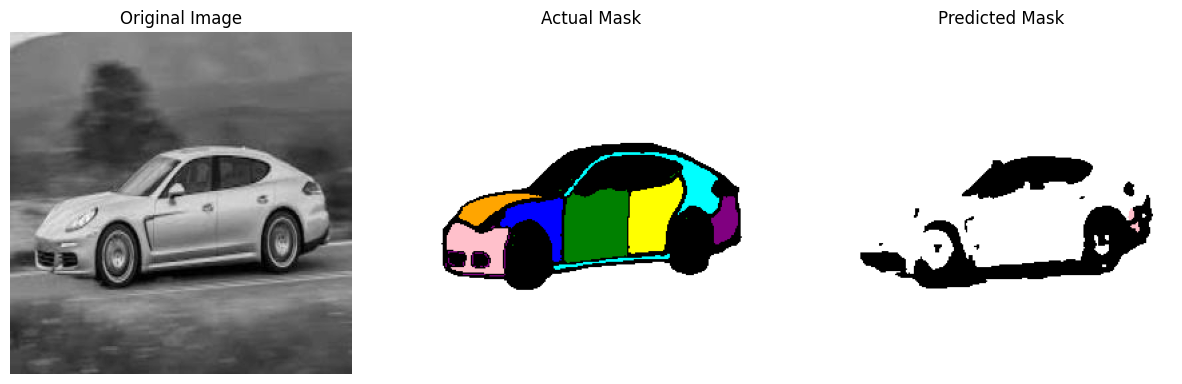

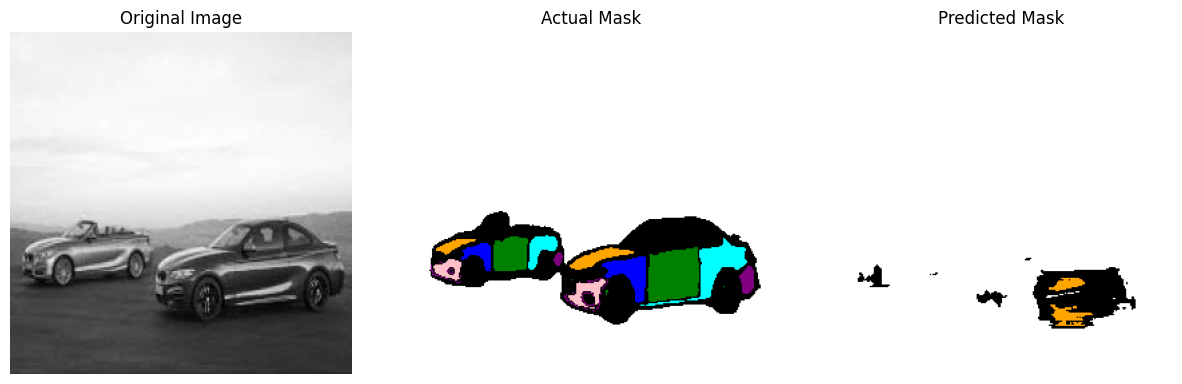

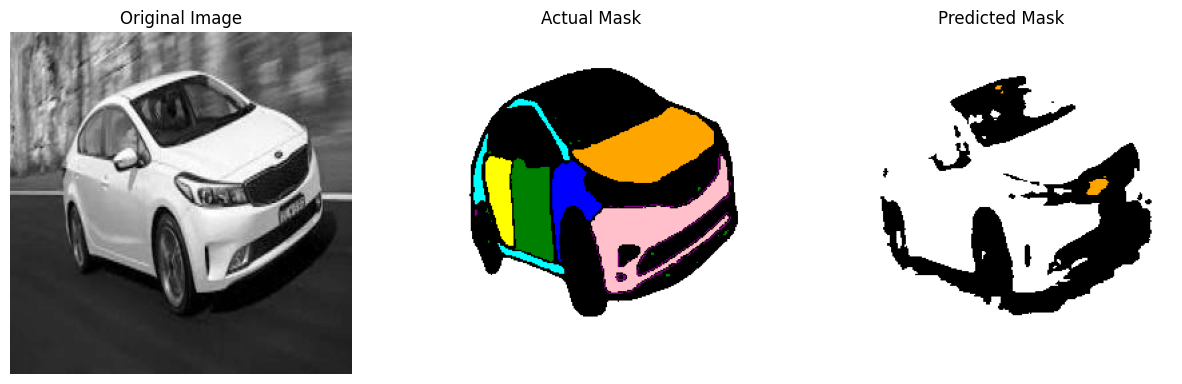

Validation:


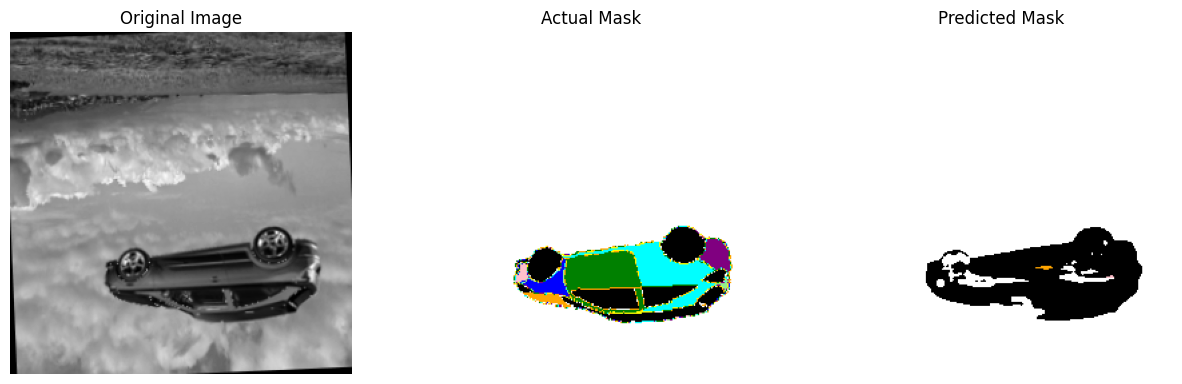

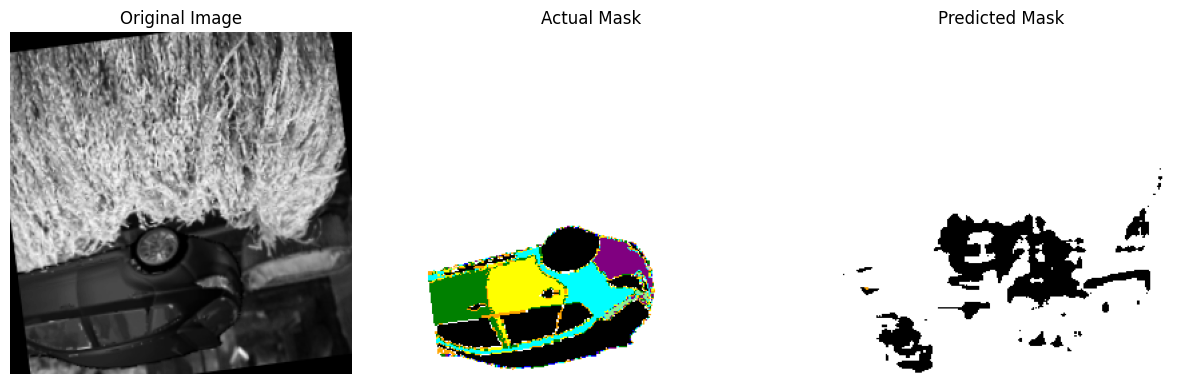

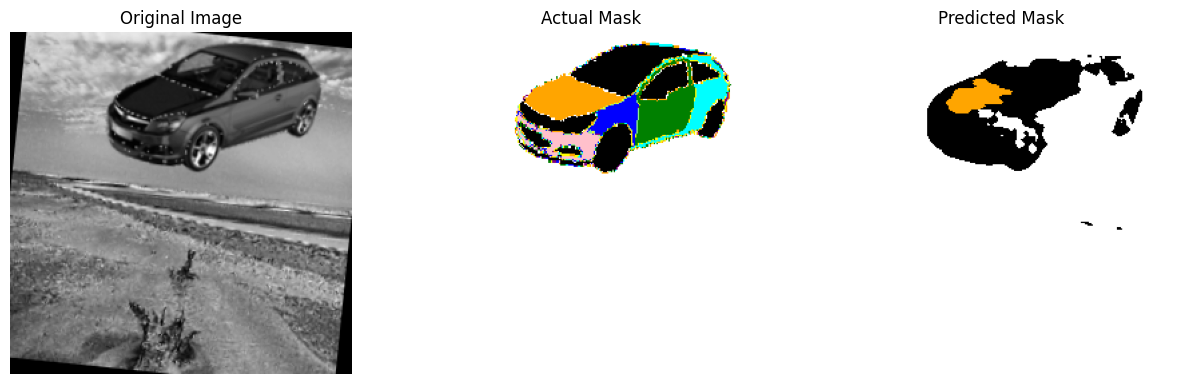

Test:


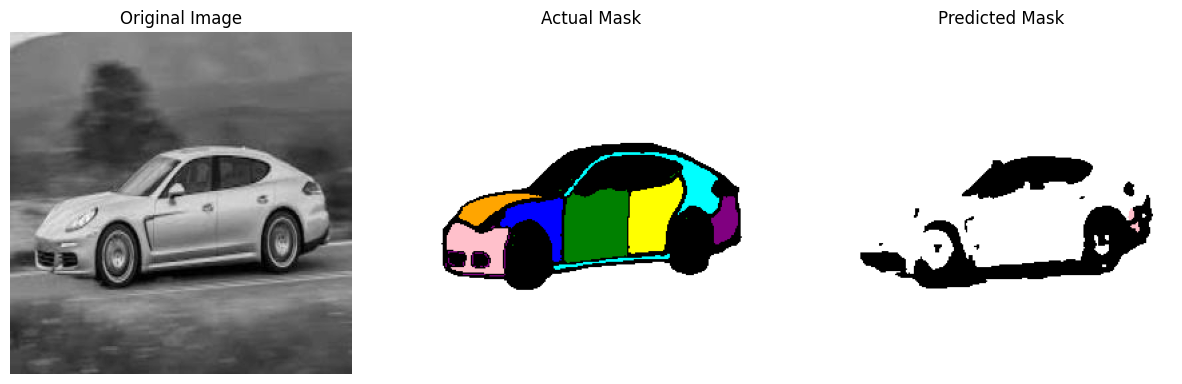

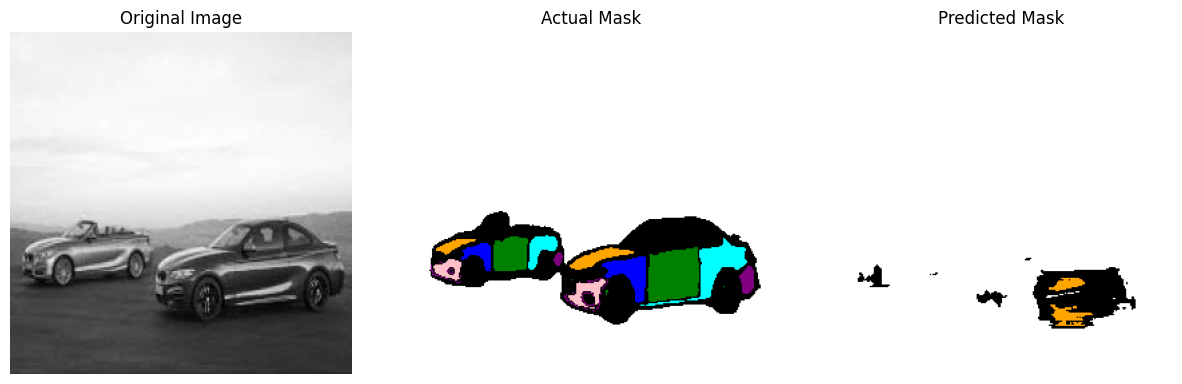

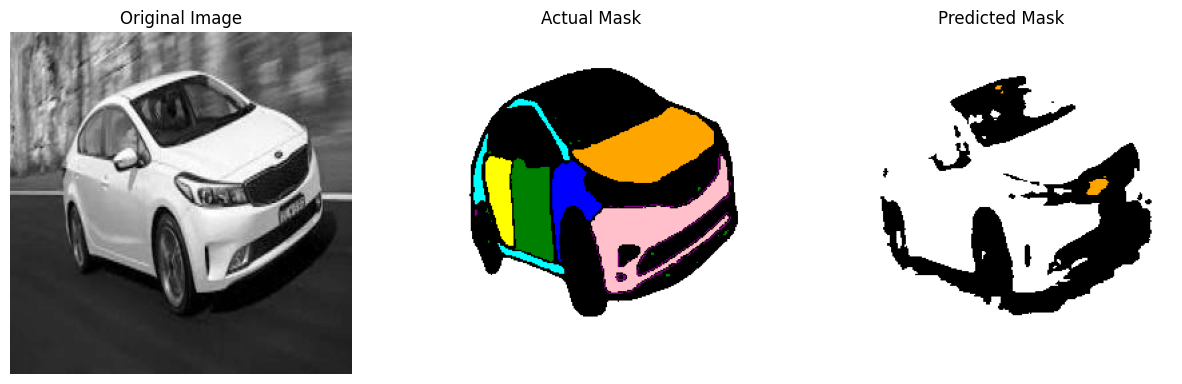

In [38]:
## Visualize results

def visualize_results(images, masks, num_examples):
    # Compares visually 'num_examples' of images with the actual and predicted mask

    # Predict masks with the model
    model.eval()
    with torch.no_grad():
        preds = model(images)

    # Take the argmax to get the class label for each pixel
    pred_masks = preds.argmax(dim=1)

    for i in range(num_examples if num_examples < batch_size else batch_size):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        img = images[i].detach().cpu().permute((1, 2, 0)).numpy()   #.astype(int)
        cmap = 'gray' if grayscale else None
        ax1.imshow(img, cmap=cmap)
        ax1.set_title('Original Image')
        ax1.axis('off')

        # Actual mask
        true_mask = segment_image(images[i], masks[i]).permute((1, 2, 0)).long()
        ax2.imshow(true_mask)
        ax2.set_title('Actual Mask')
        ax2.axis('off')

        # Predicted mask
        pred_mask = segment_image(images[i], pred_masks[i]).permute((1, 2, 0)).long()
        ax3.imshow(pred_mask)
        ax3.set_title('Predicted Mask')
        ax3.axis('off')

        plt.show()


# Get a batch of images and masks from the dataloader
print('Test:')
images, masks = next(iter(test_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=3)

print('Validation:')
images, masks = next(iter(validation_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=3)

print('Test:')
images, masks = next(iter(test_dataloader))
images, masks = images.to(device), masks.to(device)
visualize_results(images, masks, num_examples=3)

In [25]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

def calculate_accuracy(y_true, y_pred):
    accuracy = accuracy_score(y_true.flatten().detach().cpu().numpy(), y_pred.flatten().detach().cpu().numpy())
    return accuracy


def calculate_dice(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    dice_values = []
    for i in range(num_classes):
        intersection = np.sum((y_true == i) & (y_pred == i))
        total = np.sum(y_true == i) + np.sum(y_pred == i)
        dice = (2.0 * intersection + smooth) / (total + smooth)
        dice_values.append(dice)

    return np.mean(dice_values)

# def calculate_dice(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
#     dice_sum = 0.0
#     for i in range(num_classes):
#         true_class = (y_true == i)
#         pred_class = (y_pred == i)
#         intersection = torch.sum(true_class * pred_class)
#         union = torch.sum(true_class) + torch.sum(pred_class)
#         dice = (2.0 * intersection + smooth) / (union + smooth)
#         dice_sum += dice

#     return dice_sum/num_classes


def calculate_iou(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    iou_values = []
    for i in range(num_classes):
        intersection = np.sum(np.logical_and(y_true == i, y_pred == i))
        union = np.sum(np.logical_or(y_true == i, y_pred == i))
        iou = (intersection + smooth) / (union + smooth)
        iou_values.append(iou)

    return np.mean(iou_values)

# def calculate_iou(y_true, y_pred, num_classes=num_classes, smooth=1e-6):
#     iou_sum = 0.0
#     for i in range(num_classes):
#         true_class = (y_true == i)
#         pred_class = (y_pred == i)
#         intersection = torch.sum(true_class * pred_class)
#         union = torch.sum(true_class) + torch.sum(pred_class) - intersection
#         iou = (intersection + smooth) / (union + smooth)
#         iou_sum += iou

#     return iou_sum/num_classes


def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.flatten().detach().cpu().numpy(),
        pred.flatten().detach().cpu().numpy(),
        normalize=normalize,
        labels=np.arange(num_classes)
    )


In [39]:
## Evaluate test set

confusion_matrix = np.zeros((num_classes, num_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    dice_scores = []
    iou_scores = []
    for images, masks in test_dataloader:
        images, masks = images.to(device), masks.to(device)
        output = model(images)
        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller
        test_accuracies.append(calculate_accuracy(masks, predictions) * len(images))
        dice_scores.append(calculate_dice(masks, predictions))
        iou_scores.append(calculate_iou(masks, predictions))

        ccm = compute_confusion_matrix(masks, predictions)
        confusion_matrix += ccm

    test_accuracy = np.sum(test_accuracies) / len(test_dataloader.dataset)
    dice_score = np.mean(dice_scores)
    iou_score = np.mean(iou_scores)

    model.train()

In [40]:
print('Accuracy:', test_accuracy)
print('Dice:', dice_score)
print('IoU:', iou_score)
# TODO: Veit ekki alveg hvort dice og iou sé rétt reiknað hjá mér

Accuracy: 0.661609395345052
Dice: 0.14884053478355463
IoU: 0.11923152192265915


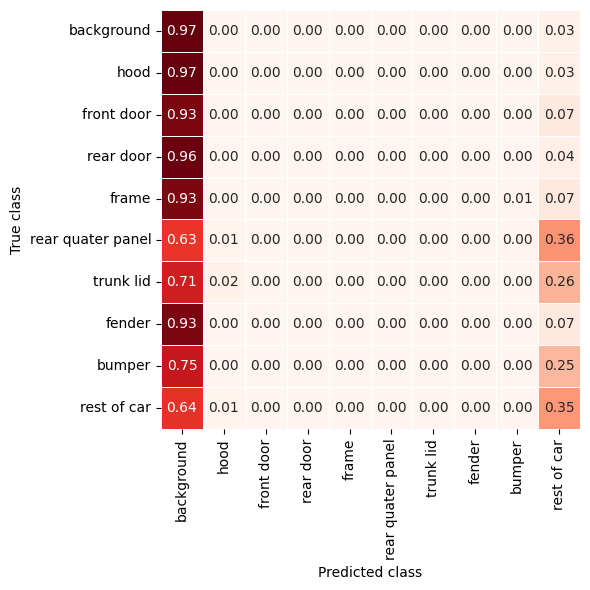

In [41]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = car_parts
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

In [ ]:
# SÍÐAN TIL ÞESS AÐ FÁ GOTT MAT Á TESTING ACCURACY/DICE SCORE ÞÁ ER KANNSKI HÆGT AÐ NOTA AÐFERÐIR EINS OG Í COMPUTATIONAL TOOLS
# T.D. CROSS VALIDATION EÐA BOOTSTRAP VALIDATION (AÐ ÞVÍ AÐ VIÐ ERUM BARA MEÐ 30 TEST SAMPLES ÞANNIG AÐ ÞAÐ ER VARLA RAUNHÆFT AÐ META
# GÆÐIN BARA Á ÞEIM)